# Heterogeneous Data Experiments

Test symmetry regularization with data heterogeneity:

## Experiment 1: Multiple Perturbation Distributions (One Animal)
- **Same decoder** (observation matrix C)
- **Different perturbation directions** (different random perturbation matrices)
- Same perturbation magnitude
- Pool all trajectories together

## Experiment 2: Multi-Animal Setting
- **Different decoders** (observation matrices) per animal
- Same underlying ring attractor
- Pool trajectories from all animals

In [28]:
# Setup
import sys
sys.path.append('../..')

%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

import xfads.utils as utils
import xfads.plot_utils as plot_utils
from xfads.ssm_modules.dynamics import DenseGaussianDynamics
from xfads.ssm_modules.likelihoods import GaussianLikelihood
from xfads.ssm_modules.dynamics import DenseGaussianInitialCondition
from xfads.ssm_modules.encoders import LocalEncoderLRMvn, BackwardEncoderLRMvn
from xfads.smoothers.nonlinear_smoother import NonlinearFilterSmallL

from regularized_ssm import RegularizedSSM, create_rotation_vector_field

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Device: cpu


In [29]:
# Config
class Config:
    n_latents = 2
    n_latents_read = 2
    n_hidden_dynamics = 32
    n_hidden_local = 32
    n_hidden_backward = 32
    rank_local = 2
    rank_backward = 2
    p_local_dropout = 0.0
    
    n_samples = 5
    batch_sz = 32
    learning_rate = 1e-3
    max_epochs = 30
    patience = 7
    grad_clip = 1.0
    
    # Data parameters
    n_trials_per_condition = 250  # Per perturbation or per animal
    n_neurons = 100
    n_time_bins = 75
    train_split = 0.8
    
    # Experiment 1: Multiple perturbations (one animal)
    n_perturbations = 4  # Number of different perturbation directions
    perturbation_magnitude = 0.15
    
    # Experiment 2: Multi-animal
    n_animals = 4
    
    # Regularization
    lambda_lie = 1e-4
    
    seed = SEED

cfg = Config()
print(f"Experiment 1: {cfg.n_perturbations} perturbation distributions, {cfg.n_trials_per_condition} trials each")
print(f"Experiment 2: {cfg.n_animals} animals, {cfg.n_trials_per_condition} trials each")
print(f"Lambda: {cfg.lambda_lie}")

Experiment 1: 4 perturbation distributions, 250 trials each
Experiment 2: 4 animals, 250 trials each
Lambda: 0.0001


In [30]:
# Load ring attractor
import importlib.util

spec = importlib.util.spec_from_file_location("test_dynamics", "test_dynamics.py")
test_dynamics = importlib.util.module_from_spec(spec)
spec.loader.exec_module(test_dynamics)
PerturbedRingAttractorDynamics = test_dynamics.PerturbedRingAttractorRNN

target_rotation_field = create_rotation_vector_field(rotation_speed=0.5)
print("Ring attractor dynamics loaded")

Ring attractor dynamics loaded


---
# Experiment 1: Multiple Perturbation Distributions (One Animal)

Same decoder, different perturbation directions

In [31]:
print("=" * 60)
print("EXPERIMENT 1: Multiple Perturbation Distributions")
print("=" * 60)

# Create ONE observation matrix (same decoder)
C_exp1 = utils.FanInLinear(cfg.n_latents, cfg.n_neurons, device=device).requires_grad_(False)
Q_diag = 5e-3 * torch.ones(cfg.n_latents, device=device)
Q_0_diag = 1.0 * torch.ones(cfg.n_latents, device=device)
R_diag = 1e-1 * torch.ones(cfg.n_neurons, device=device)
m_0 = torch.zeros(cfg.n_latents, device=device)

# Generate data from MULTIPLE perturbation distributions
z_all = []
y_all = []

print(f"\nGenerating data from {cfg.n_perturbations} different perturbation distributions...")
for i in range(cfg.n_perturbations):
    # Create ring attractor with DIFFERENT perturbation (different random seed)
    torch.manual_seed(SEED + i * 1000)  # Different seed = different perturbation direction
    
    dynamics = PerturbedRingAttractorDynamics(
        bin_sz=1e-1,
        lengthscale=0.2,
        perturbation_magnitude=cfg.perturbation_magnitude
    ).to(device)
    
    # Generate trajectories
    z = utils.sample_gauss_z(dynamics, Q_diag, m_0, Q_0_diag, 
                            cfg.n_trials_per_condition, cfg.n_time_bins)
    y = C_exp1(z) + torch.sqrt(R_diag) * torch.randn(
        (cfg.n_trials_per_condition, cfg.n_time_bins, cfg.n_neurons), device=device)
    
    z_all.append(z)
    y_all.append(y)
    
    print(f"  Perturbation {i+1}: {cfg.n_trials_per_condition} trials")

# Pool all data together
z_exp1 = torch.cat(z_all, dim=0).detach()
y_exp1 = torch.cat(y_all, dim=0).detach()

# Shuffle
torch.manual_seed(SEED)
shuffle_idx = torch.randperm(y_exp1.shape[0])
z_exp1 = z_exp1[shuffle_idx]
y_exp1 = y_exp1[shuffle_idx]

n_train_exp1 = int(cfg.train_split * y_exp1.shape[0])
y_train_exp1 = y_exp1[:n_train_exp1]
y_valid_exp1 = y_exp1[n_train_exp1:]

print(f"\n✅ Experiment 1 data ready:")
print(f"   Total: {y_exp1.shape[0]} trials (pooled from {cfg.n_perturbations} perturbations)")
print(f"   Train: {y_train_exp1.shape[0]} trials")
print(f"   Valid: {y_valid_exp1.shape[0]} trials")
print(f"   Same decoder for all!")

EXPERIMENT 1: Multiple Perturbation Distributions

Generating data from 4 different perturbation distributions...
  Perturbation 1: 250 trials
  Perturbation 2: 250 trials
  Perturbation 3: 250 trials
  Perturbation 4: 250 trials

✅ Experiment 1 data ready:
   Total: 1000 trials (pooled from 4 perturbations)
   Train: 800 trials
   Valid: 200 trials
   Same decoder for all!


---
# Experiment 2: Multi-Animal Setting

Different decoders per animal

In [32]:
print("\n" + "=" * 60)
print("EXPERIMENT 2: Multi-Animal Setting")
print("=" * 60)

# Create DIFFERENT observation matrices per animal
C_animals = []
for i in range(cfg.n_animals):
    torch.manual_seed(SEED + i * 100)
    C = utils.FanInLinear(cfg.n_latents, cfg.n_neurons, device=device).requires_grad_(False)
    C_animals.append(C)

# Use SAME underlying dynamics (one perturbation)
torch.manual_seed(SEED)
dynamics_exp2 = PerturbedRingAttractorDynamics(
    bin_sz=1e-1,
    lengthscale=0.2,
    perturbation_magnitude=cfg.perturbation_magnitude
).to(device)

# Generate data for each animal
z_all_animals = []
y_all_animals = []

print(f"\nGenerating data from {cfg.n_animals} different animals...")
for i in range(cfg.n_animals):
    # Same dynamics, different observation matrix
    z = utils.sample_gauss_z(dynamics_exp2, Q_diag, m_0, Q_0_diag,
                            cfg.n_trials_per_condition, cfg.n_time_bins)
    y = C_animals[i](z) + torch.sqrt(R_diag) * torch.randn(
        (cfg.n_trials_per_condition, cfg.n_time_bins, cfg.n_neurons), device=device)
    
    z_all_animals.append(z)
    y_all_animals.append(y)
    
    print(f"  Animal {i+1}: {cfg.n_trials_per_condition} trials (unique decoder)")

# Pool all data together
z_exp2 = torch.cat(z_all_animals, dim=0).detach()
y_exp2 = torch.cat(y_all_animals, dim=0).detach()

# Shuffle
torch.manual_seed(SEED)
shuffle_idx = torch.randperm(y_exp2.shape[0])
z_exp2 = z_exp2[shuffle_idx]
y_exp2 = y_exp2[shuffle_idx]

n_train_exp2 = int(cfg.train_split * y_exp2.shape[0])
y_train_exp2 = y_exp2[:n_train_exp2]
y_valid_exp2 = y_exp2[n_train_exp2:]

print(f"\n✅ Experiment 2 data ready:")
print(f"   Total: {y_exp2.shape[0]} trials (pooled from {cfg.n_animals} animals)")
print(f"   Train: {y_train_exp2.shape[0]} trials")
print(f"   Valid: {y_valid_exp2.shape[0]} trials")
print(f"   Different decoder for each animal!")


EXPERIMENT 2: Multi-Animal Setting

Generating data from 4 different animals...
  Animal 1: 250 trials (unique decoder)
  Animal 2: 250 trials (unique decoder)
  Animal 3: 250 trials (unique decoder)
  Animal 4: 250 trials (unique decoder)

✅ Experiment 2 data ready:
   Total: 1000 trials (pooled from 4 animals)
   Train: 800 trials
   Valid: 200 trials
   Different decoder for each animal!


In [33]:
# Model factory
def create_ssm(lambda_lie, C_matrix):
    """Create SSM with specified observation matrix."""
    H = utils.ReadoutLatentMask(cfg.n_latents, cfg.n_latents_read)
    readout_fn = nn.Sequential(H, C_matrix)
    likelihood_pdf = GaussianLikelihood(readout_fn, cfg.n_neurons, R_diag, device=device, fix_R=True)

    dynamics_fn = utils.build_gru_dynamics_function(cfg.n_latents, cfg.n_hidden_dynamics, device=device)
    dynamics_mod = DenseGaussianDynamics(dynamics_fn, cfg.n_latents, Q_diag, device=device)

    initial_condition_pdf = DenseGaussianInitialCondition(cfg.n_latents, m_0, Q_0_diag, device=device)

    backward_encoder = BackwardEncoderLRMvn(
        cfg.n_latents, cfg.n_hidden_backward, cfg.n_latents,
        rank_local=cfg.rank_local, rank_backward=cfg.rank_backward, device=device
    )
    local_encoder = LocalEncoderLRMvn(
        cfg.n_latents, cfg.n_neurons, cfg.n_hidden_local, cfg.n_latents,
        rank=cfg.rank_local, device=device, dropout=cfg.p_local_dropout
    )

    nl_filter = NonlinearFilterSmallL(dynamics_mod, initial_condition_pdf, device=device)

    ssm = RegularizedSSM(
        dynamics_mod=dynamics_mod,
        likelihood_pdf=likelihood_pdf,
        initial_c_pdf=initial_condition_pdf,
        backward_encoder=backward_encoder,
        local_encoder=local_encoder,
        nl_filter=nl_filter,
        target_vector_field=target_rotation_field if lambda_lie > 0 else None,
        lambda_lie=lambda_lie,
        lambda_curvature=0.0,
        lie_normalize="yang" if lambda_lie > 0 else None,
        device=device
    )
    return ssm

# Training function
def train_model(ssm, y_train, y_valid, name="model"):
    optimizer = torch.optim.Adam(ssm.parameters(), lr=cfg.learning_rate)
    
    best_valid_elbo = float('inf')
    patience_counter = 0
    best_model_state = None
    
    print(f"Training {name}...")
    for epoch in range(1, cfg.max_epochs + 1):
        ssm.train()
        train_losses = []
        indices = torch.randperm(len(y_train))
        
        for i in range(0, len(y_train), cfg.batch_sz):
            batch_indices = indices[i:i+cfg.batch_sz]
            y_batch = y_train[batch_indices]
            
            optimizer.zero_grad()
            total_loss, _, stats = ssm(y_batch, cfg.n_samples)
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(ssm.parameters(), cfg.grad_clip)
            optimizer.step()
            
            train_losses.append(stats)
        
        ssm.eval()
        with torch.no_grad():
            valid_total_loss, _, valid_stats = ssm(y_valid, cfg.n_samples)
        
        current_valid_elbo = valid_stats['elbo_loss'].item()
        
        if current_valid_elbo < best_valid_elbo:
            best_valid_elbo = current_valid_elbo
            patience_counter = 0
            best_model_state = {k: v.cpu() for k, v in ssm.state_dict().items()}
        else:
            patience_counter += 1
        
        if epoch % 5 == 0:
            print(f"  Epoch {epoch}: Valid ELBO = {current_valid_elbo:.3f}, Patience = {patience_counter}/{cfg.patience}")
        
        if patience_counter >= cfg.patience:
            print(f"  Early stopping at epoch {epoch}")
            break
    
    if best_model_state is not None:
        ssm.load_state_dict(best_model_state)
    
    # Compute final stats on validation set
    ssm.eval()
    with torch.no_grad():
        _, _, final_stats = ssm(y_valid, cfg.n_samples)
    
    results = {
        'elbo': final_stats['elbo_loss'].item(),
        'lie_loss': final_stats.get('lie_loss', torch.tensor(0.0)).item(),
        'kl_loss': final_stats.get('kl_loss', torch.tensor(0.0)).item(),
        'recon_loss': final_stats.get('recon_loss', torch.tensor(0.0)).item(),
    }
    
    print(f"  Final Valid ELBO: {results['elbo']:.3f}, Lie Loss: {results['lie_loss']:.4f}")
    
    return results

print("Model and training functions ready")

Model and training functions ready


---
# Run Experiment 1

In [34]:
print("\n" + "=" * 60)
print("Training Experiment 1: Multiple Perturbations")
print("=" * 60)

# Baseline
torch.manual_seed(SEED)
ssm_exp1_baseline = create_ssm(lambda_lie=0.0, C_matrix=C_exp1)
stats_exp1_baseline = train_model(ssm_exp1_baseline, y_train_exp1, y_valid_exp1, "Exp1 Baseline")

# Regularized
torch.manual_seed(SEED)
ssm_exp1_reg = create_ssm(lambda_lie=cfg.lambda_lie, C_matrix=C_exp1)
stats_exp1_reg = train_model(ssm_exp1_reg, y_train_exp1, y_valid_exp1, "Exp1 Regularized")

print(f"\n📊 Experiment 1 Results:")
print(f"   Baseline:")
print(f"     ELBO: {stats_exp1_baseline['elbo']:.3f}")
print(f"     Lie Loss: {stats_exp1_baseline['lie_loss']:.4f}")
print(f"   Regularized:")
print(f"     ELBO: {stats_exp1_reg['elbo']:.3f}")
print(f"     Lie Loss: {stats_exp1_reg['lie_loss']:.4f}")
print(f"   Improvement: {stats_exp1_baseline['elbo'] - stats_exp1_reg['elbo']:.3f}")


Training Experiment 1: Multiple Perturbations
Training Exp1 Baseline...
  Epoch 5: Valid ELBO = 10867.929, Patience = 0/7
  Epoch 10: Valid ELBO = 2667.403, Patience = 0/7
  Epoch 15: Valid ELBO = 2472.679, Patience = 0/7
  Epoch 20: Valid ELBO = 2388.331, Patience = 0/7
  Epoch 25: Valid ELBO = 2330.630, Patience = 0/7
  Epoch 30: Valid ELBO = 2315.477, Patience = 0/7
  Final Valid ELBO: 2315.338, Lie Loss: 0.0000
Training Exp1 Regularized...
  Epoch 5: Valid ELBO = 12932.110, Patience = 0/7
  Epoch 10: Valid ELBO = 2622.486, Patience = 0/7
  Epoch 15: Valid ELBO = 2431.663, Patience = 0/7
  Epoch 20: Valid ELBO = 2360.888, Patience = 0/7
  Epoch 25: Valid ELBO = 2319.839, Patience = 0/7
  Epoch 30: Valid ELBO = 2312.424, Patience = 0/7
  Final Valid ELBO: 2310.906, Lie Loss: 11.9972

📊 Experiment 1 Results:
   Baseline:
     ELBO: 2315.338
     Lie Loss: 0.0000
   Regularized:
     ELBO: 2310.906
     Lie Loss: 11.9972
   Improvement: 4.432


---
# Run Experiment 2

In [ ]:
print("\n" + "=" * 60)
print("Training Experiment 2: Multi-Animal")
print("=" * 60)

# Use first animal's C matrix (or could average, but simplest is to pick one)
C_exp2 = C_animals[0]

# Baseline
torch.manual_seed(SEED)
ssm_exp2_baseline = create_ssm(lambda_lie=0.0, C_matrix=C_exp2)
stats_exp2_baseline = train_model(ssm_exp2_baseline, y_train_exp2, y_valid_exp2, "Exp2 Baseline")

# Regularized
torch.manual_seed(SEED)
ssm_exp2_reg = create_ssm(lambda_lie=cfg.lambda_lie, C_matrix=C_exp2)
stats_exp2_reg = train_model(ssm_exp2_reg, y_train_exp2, y_valid_exp2, "Exp2 Regularized")

print(f"\n📊 Experiment 2 Results:")
print(f"   Baseline:")
print(f"     ELBO: {stats_exp2_baseline['elbo']:.3f}")
print(f"     Lie Loss: {stats_exp2_baseline['lie_loss']:.4f}")
print(f"   Regularized:")
print(f"     ELBO: {stats_exp2_reg['elbo']:.3f}")
print(f"     Lie Loss: {stats_exp2_reg['lie_loss']:.4f}")
print(f"   Improvement: {stats_exp2_baseline['elbo'] - stats_exp2_reg['elbo']:.3f}")


Training Experiment 2: Multi-Animal
Training Exp2 Baseline...
  Epoch 5: Valid ELBO = 22799.795, Patience = 0/7
  Epoch 10: Valid ELBO = 19211.523, Patience = 0/7
  Epoch 15: Valid ELBO = 19013.529, Patience = 0/7
  Epoch 20: Valid ELBO = 18957.832, Patience = 0/7
  Epoch 25: Valid ELBO = 18912.721, Patience = 0/7
  Epoch 30: Valid ELBO = 18887.645, Patience = 0/7
  Final Valid ELBO: 18890.355, Lie Loss: 0.0000
Training Exp2 Regularized...
  Epoch 5: Valid ELBO = 23569.574, Patience = 0/7
  Epoch 10: Valid ELBO = 20665.426, Patience = 0/7
  Epoch 15: Valid ELBO = 19030.236, Patience = 0/7
  Epoch 20: Valid ELBO = 18958.369, Patience = 0/7
  Epoch 25: Valid ELBO = 18920.439, Patience = 0/7
  Epoch 30: Valid ELBO = 18893.105, Patience = 0/7
  Final Valid ELBO: 18897.189, Lie Loss: 150.0205

📊 Experiment 2 Results:
   Baseline:
     ELBO: 18890.355
     Lie Loss: 0.0000
   Regularized:
     ELBO: 18897.189
     Lie Loss: 150.0205
   Improvement: -6.834


---
# Visualize Results

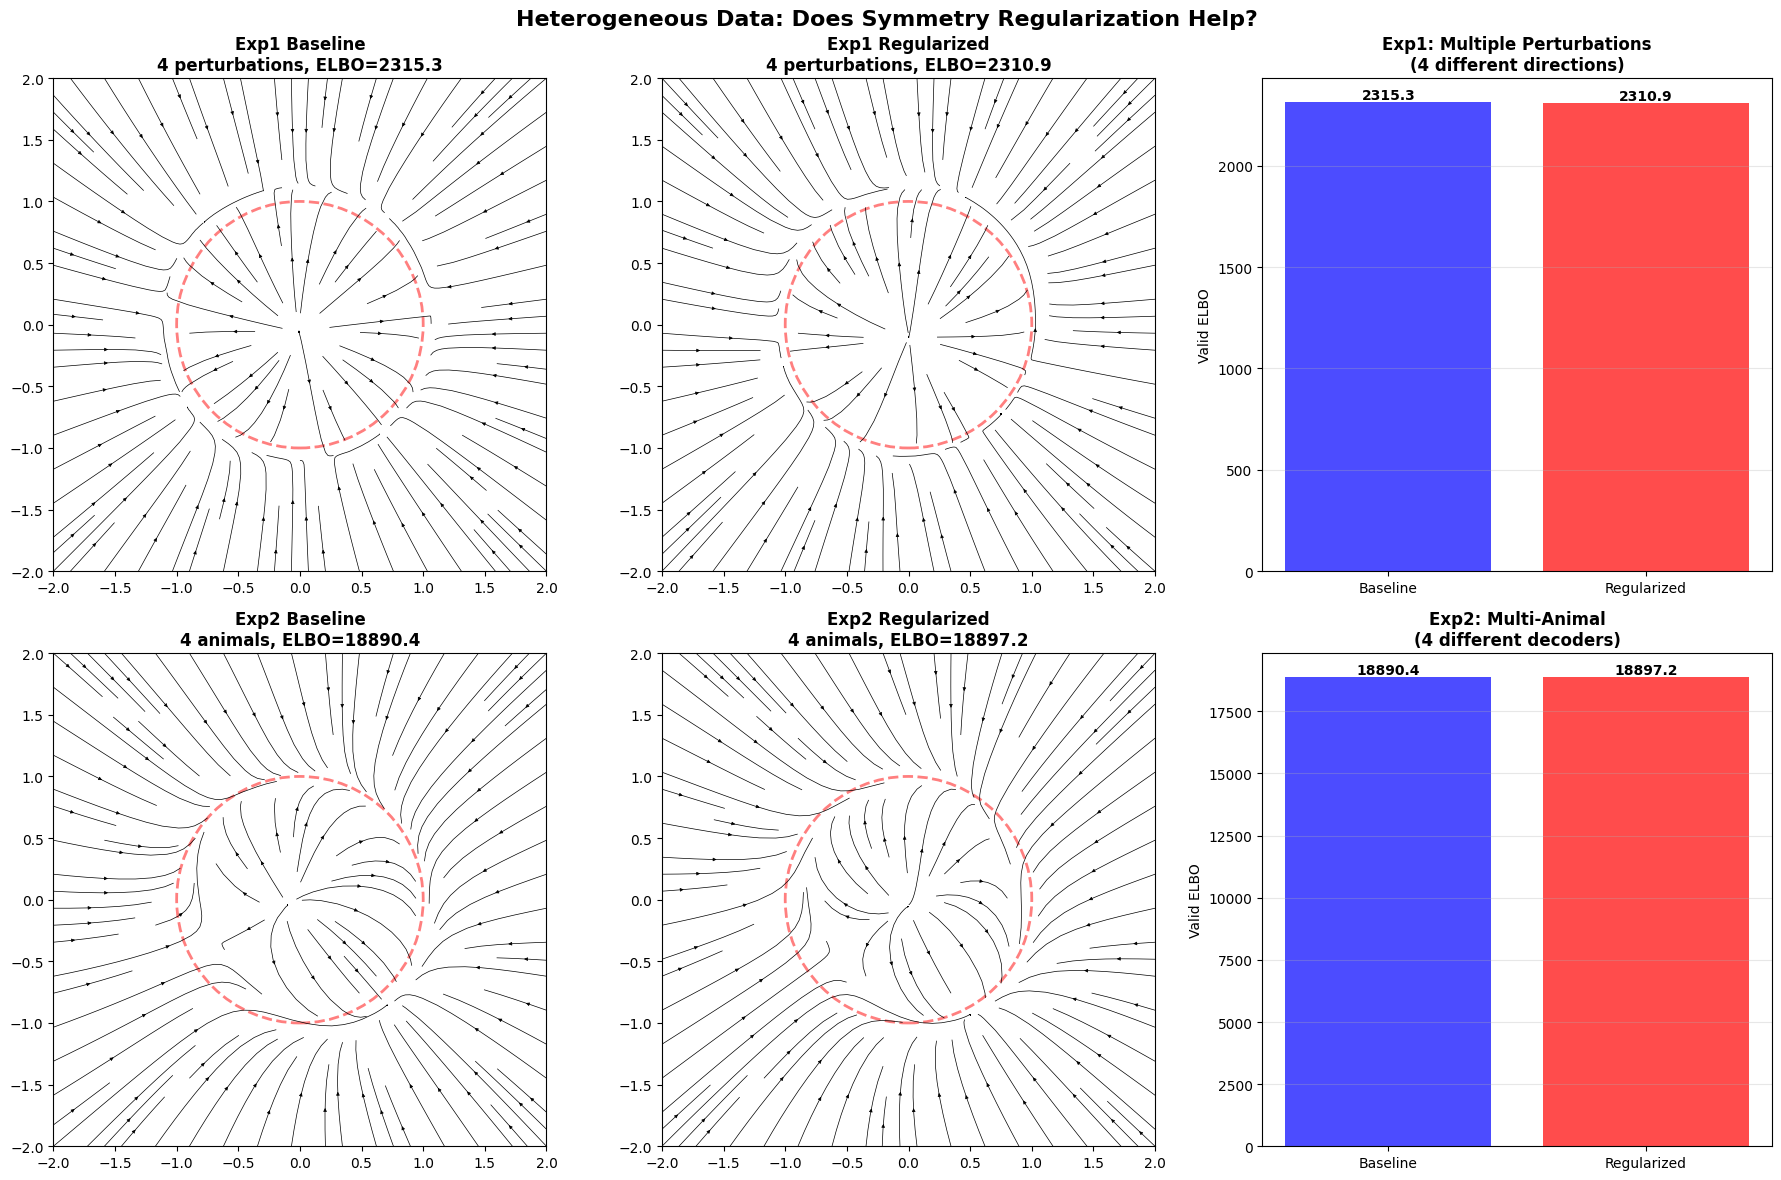


✅ Saved: heterogeneous_data_results.png


In [36]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Exp 1: Baseline
ax = axes[0, 0]
ssm_exp1_baseline.eval()
plot_utils.plot_two_d_vector_field(ssm_exp1_baseline.dynamics_mod.mean_fn, ax, min_xy=-2, max_xy=2)
circle = plt.Circle((0, 0), 1.0, fill=False, color='red', linewidth=2, alpha=0.5, linestyle='--')
ax.add_patch(circle)
ax.set_title(f'Exp1 Baseline\n{cfg.n_perturbations} perturbations, ELBO={stats_exp1_baseline["elbo"]:.1f}', fontweight='bold')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')

# Exp 1: Regularized
ax = axes[0, 1]
ssm_exp1_reg.eval()
plot_utils.plot_two_d_vector_field(ssm_exp1_reg.dynamics_mod.mean_fn, ax, min_xy=-2, max_xy=2)
circle = plt.Circle((0, 0), 1.0, fill=False, color='red', linewidth=2, alpha=0.5, linestyle='--')
ax.add_patch(circle)
ax.set_title(f'Exp1 Regularized\n{cfg.n_perturbations} perturbations, ELBO={stats_exp1_reg["elbo"]:.1f}', fontweight='bold')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')

# Exp 1: ELBO comparison
ax = axes[0, 2]
bars = ax.bar(['Baseline', 'Regularized'], [stats_exp1_baseline['elbo'], stats_exp1_reg['elbo']],
              color=['blue', 'red'], alpha=0.7)
ax.set_ylabel('Valid ELBO')
ax.set_title(f'Exp1: Multiple Perturbations\n({cfg.n_perturbations} different directions)', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}', ha='center', va='bottom', fontweight='bold')

# Exp 2: Baseline
ax = axes[1, 0]
ssm_exp2_baseline.eval()
plot_utils.plot_two_d_vector_field(ssm_exp2_baseline.dynamics_mod.mean_fn, ax, min_xy=-2, max_xy=2)
circle = plt.Circle((0, 0), 1.0, fill=False, color='red', linewidth=2, alpha=0.5, linestyle='--')
ax.add_patch(circle)
ax.set_title(f'Exp2 Baseline\n{cfg.n_animals} animals, ELBO={stats_exp2_baseline["elbo"]:.1f}', fontweight='bold')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')

# Exp 2: Regularized
ax = axes[1, 1]
ssm_exp2_reg.eval()
plot_utils.plot_two_d_vector_field(ssm_exp2_reg.dynamics_mod.mean_fn, ax, min_xy=-2, max_xy=2)
circle = plt.Circle((0, 0), 1.0, fill=False, color='red', linewidth=2, alpha=0.5, linestyle='--')
ax.add_patch(circle)
ax.set_title(f'Exp2 Regularized\n{cfg.n_animals} animals, ELBO={stats_exp2_reg["elbo"]:.1f}', fontweight='bold')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')

# Exp 2: ELBO comparison
ax = axes[1, 2]
bars = ax.bar(['Baseline', 'Regularized'], [stats_exp2_baseline['elbo'], stats_exp2_reg['elbo']],
              color=['blue', 'red'], alpha=0.7)
ax.set_ylabel('Valid ELBO')
ax.set_title(f'Exp2: Multi-Animal\n({cfg.n_animals} different decoders)', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}', ha='center', va='bottom', fontweight='bold')

plt.suptitle('Heterogeneous Data: Does Symmetry Regularization Help?', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('heterogeneous_data_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Saved: heterogeneous_data_results.png")